# LDA - Linear Discriminant Analysis

The goal of the LDA technique is to project the original data matrix onto a lower dimensional space. To achieve this goal, three steps needed to be performed:

1) The first step is to calculate the separability between different classes, which is called the between-class variance or between-class matrix. 
2) The second step is to calculate the distance between the mean and the samples of each class, which is called the within-class variance or within-class matrix.
3) The third step is to construct the lower dimensional space which maximizes the between-class variance and minimizes the within class variance

We denote the between class variance of the class i as $S_{Bi}$. Suppose to have a dataset $X = \{x_{1},...,x_{N}\}$ where $x_{i} \in \mathbb{R}^M$. Each sample $x_{i}$ has M features and there are N samples. The separation distance between different classes which is denoted by $(m_{i} − m)$ will be calculated as follows:
$(m_{i} - m)^2 = (W^T\mu_{i} - W^T\mu)^2 = W^T(\mu_{i}-\mu)(\mu_{i}-\mu)^TW$
* $m_{i}$ is the projection of the mean of the class i, $m_{i} = W^T\mu_{i}$
* $m$ is the projection of the mean of the class i, $m = W^T\mu$
* $\mu_{i}$ is the mean of the class i
* $\mu$ is the mean of the dataset, $\mu = \frac{1}{N}\sum\limits_{i=1}^N \frac{n_{i}\mu_{i}}{N}$
* W is the transformation matrix of LDA

Moreover we can express $(m_{i}-m)^2 = W^TS_{Bi}W$ and $S_{B} = \frac{1}{N}\sum\limits_{i=1}^c n_{i}S_{Bi}$ is the sum of all the "between class covariance"

The within-class variance of the j-th class ($S_{Wi
j}$) represents the difference between the mean and the samples of that class.
For the class j: $S_{Wj} = \frac{1}{n_{j}}\sum\limits_{i=1}^{n_{j}} (x_{i,j} - \mu_{j})(x_{i,j} - \mu_{j})^T$

After having computed $S_{Wj}$ for each class j we can compute the within class variance as follows: $S_{W} = \frac{1}{N}\sum\limits_{j=1}^c n_{j}S_{Wj}$

In conclusion we have:
$$ S_{W} = \frac{1}{N}\sum\limits_{i=1}^c n_{i}S_{Wi} \;,\; S_{Wj} = \frac{1}{n_{j}}\sum\limits_{i=1}^{n_{j}} (x_{i,j} - \mu_{j})(x_{i,j} - \mu_{j})^T$$
$$ S_{B} = \frac{1}{N}\sum\limits_{i=1}^c n_{i}S_{Bi} \;,\; S_{Bi} = (\mu_{i}-\mu)(\mu_{i}-\mu)^T $$

After having computed $S_{W}$ and $S_{B}$ the transformation matrix $W$ of the LDA technique can be calculed throug the Fisher criterion: $arg \max\limits_{W} = \frac{W S_{B} W^T}{W S_{W} W^T}$. Optimal solution $W$ can be found by solving the eigenvalue problem: $S_{W} W = \lambda S_{B} W$.
The solution can be obtained by computing the eigenvalues $\lambda=\{\lambda_{1},...,\lambda_{M}\}$ and the eigenvectors $V = \{v_{1},...,v_{M}\}$ of the matrix $W=S_{W}^{-1}S_{B}$.
Each eigenvector represents one axis of the LDA space, and the associated eigenvalue represents the robustness of this eigenvector. The robustness of the eigenvector reflects its ability to discriminate between different classes, i.e. increase the between-class variance, and decreases the withinclass variance of each class; hence meets the LDA goal. Thus, the eigenvectors with the $m$ highest eigenvalues are used to construct a lower dimensional space $(V_{m})$.

## Numerical example - IRIS dataset

In [69]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import scipy
def load():
    return sklearn.datasets.load_iris()['data'].T, sklearn.datasets.load_iris()['target']
D,labels = load()

First we have to compute the between class variance $S_{B}$ and the within class variance $S_{W}$. 

Lets start from $S_{B} = \frac{1}{N}\sum\limits_{c=1}^K n_{c}(\mu_{c} - \mu)(\mu_{c}-\mu)^T$ where $K$ is the number of classes(3 in our case) and N is the total number of samples(150 in our case):

In [70]:
K = len(set(labels))
N = D.shape[1]
nc = np.array([np.sum(labels==i) for i in set(labels)]) # number of samples for each class

(1) Computation of the dataset mean $\mu$:

In [71]:
mu = D.mean(axis=1).reshape(-1,1) # column array with the mean of the data (representative point)

(2) Computation of $\mu_{c}$:

I build the matrix `mu_matrix` that contains one column for each $\mu_{c}$ minus the mean of the dataset `mu`.

In [72]:
mu_matrix = np.zeros(shape=(4,3))
for i in set(labels):
    iris_class_i = D[:,labels == i]
    iris_class_i_mean = np.mean(iris_class_i, axis=1).reshape(-1,1)
    mu_matrix[:,i:i+1] = iris_class_i_mean
mu_matrix -= mu

(3) Computation of the whole matrix $S_{B}$:

In [73]:
SB = 0
for i in range(K):
    SB += nc[i] * np.dot(mu_matrix[:,i:i+1], mu_matrix[:,i:i+1].T)
SB /= N

(4) Computation of $S_{W}$:

In [74]:
SWc = 0
SW = 0
for i in range(K):
    iris_class_i = D[:,labels == i]
    iris_class_i_mean = np.mean(iris_class_i, axis=1).reshape(-1,1)
    iris_class_i_centered = iris_class_i - iris_class_i_mean # center the samples of class i by subtracting the mean of the class
    SWc = 1/nc[i] * np.dot(iris_class_i_centered, iris_class_i_centered.T)
    SW += nc[i] * SWc # outer summary
SW /= N

Now we can solve the eigenvalue problem $S_{W} W = \lambda S_{B} W$.

In [75]:
m = K-1
sigma, U = scipy.linalg.eigh(SB, SW)
W = U[:, ::-1][:, 0:m]
W

array([[ 0.83779794,  0.02434685],
       [ 1.55005187,  2.18649663],
       [-2.22355955, -0.94138258],
       [-2.83899363,  2.86801283]])

The column of $W$ are not necessarly othonormal, but we can find a basis of that subspace

In [76]:
UW, _, _ = np.linalg.svd(W)
Wnorm = UW[:, 0:m]
Wnorm

array([[-0.16188578, -0.13894884],
       [-0.01900807, -0.76893743],
       [ 0.31480747,  0.57834653],
       [ 0.93505505, -0.23440081]])

The maximum number of dimensions that we can find is C-1. Since there are three classes of iris i can find at most 2 new dimensions. To compute the 'new' features of the dataset we have to project the dataset D along the new directions W: 

In [77]:
y = np.dot(W.T,D)

Now it's possible to plot the samples according to the 'new features' computed. We can notice that the new directions allow to separate better the classes rather than with the PCA

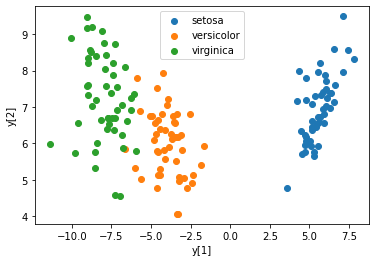

In [78]:
plt.figure()
for i in range(K):
    plt.scatter(y[:,labels==i][0,:], y[:,labels==i][1,:])
plt.xlabel('y[1]')
plt.ylabel('y[2]')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

### Second approach
Another possible approach, instead of solving the eigenvalue problem, is the diagonalization of $S_{B}$ and $S_{W}$